# Provisioning Factors, Master Thesis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

## Loading the dataset

Load the data, remove inf values and extract countries, variables

In [2]:
all_in_one = pd.read_csv('../data/all_in_one.csv', index_col=0)

In [3]:
all_in_one_no_inf = all_in_one.replace([np.inf, -np.inf], np.nan)
all_variables = all_in_one_no_inf.drop(columns=["Year", "Country.Code", "Country.Name"])
all_countries = all_in_one_no_inf['Country.Name'].unique()

Apply basic styles and a color scheme to all plots

In [4]:
# Prepare a color palette for all unique countries in the dataset
sns.set_theme(style="dark")
palette = dict(zip(all_countries, sns.color_palette("husl", len(all_countries))))

Create panel data set for each outcome variable.
Start with year 1995 where ecirank data is available, end with 2015, the last year for which energy data is available. 
Only keep observations where energy use data is available.
Remove selected columns (selection process?)

In [5]:
all_in_one_selected_years = all_in_one_no_inf.loc[all_in_one_no_inf['Year'].between(1995, 2015)]
all_in_one_selected_years_with_energy_only = all_in_one_selected_years[
    all_in_one_selected_years[['energy']].notnull().all(1)]

Drop stock variables, only keep flow

In [6]:
stock_variables = ['netmigration', 'wealth', 'patents', 'concentration', 'selfemployed', 'grosscapital', 'gdppercap',
                   'gnipercap']
all_in_one_selected_cols = all_in_one_selected_years_with_energy_only.drop(
    columns=stock_variables)

For cross-sectional analysis filter the data frame by year 2012

In [7]:
all_in_one_selected_cols_2012 = all_in_one_selected_cols.loc[
    all_in_one_selected_cols['Year'] == 2012]

Begin subsetting the data. Assign outcome variables and indicators to separate data frames.

In [8]:
from functions.create_panel_dataset import remove_cols_with_few_observations, create_outcome_df_with_metadata, \
    remove_outliers_iqr

outcome_variables = ['lifeexpectancy_over_energy', 'nutrition_over_energy', 'education_over_energy',
                     'sanitation_over_energy']
indicator_index_offset = 3
outcome_index_offset = 17

Create separate data frames containing observations with data available for each outcome variable. Remove columns with few observations.
After subsetting is done, create final data frames with metadata.

In [9]:
outcome_dfs_with_metadata = {}
for outcome in outcome_variables:
    outcome_df = all_in_one_selected_cols.dropna(subset=[outcome])
    outcome_df_no_outliers = remove_outliers_iqr(outcome_df)
    outcome_df_no_outliers_no_few_obs = remove_cols_with_few_observations(outcome_df_no_outliers)

    outcome_df_with_metadata = create_outcome_df_with_metadata(
        outcome_df_no_outliers_no_few_obs, outcome, indicator_index_offset, outcome_index_offset
    )
    outcome_dfs_with_metadata[outcome] = outcome_df_with_metadata

## Exploratory analysis

Create a summary data frame for each outcome variable containing the number of observations, countries and years.

In [10]:
from functions.exploratory_analysis import create_summary_df

In [11]:
summary_dfs = {}
indicator_dfs = {}
outcome_dfs = {}
for outcome in outcome_variables:
    outcome_df_with_metadata = outcome_dfs_with_metadata[outcome]
    outcome_df = outcome_df_with_metadata[f"{outcome}_df"]
    outcome_indicators = outcome_df_with_metadata[f"{outcome}_indicators"]
    outcome_outcomes = outcome_df_with_metadata[f"{outcome}_outcome"]
    outcome_countries = outcome_df_with_metadata[f"{outcome}_countries"]
    outcome_variables = outcome_df_with_metadata[f"{outcome}_variables"]
    summary_df = create_summary_df(outcome_df, outcome_countries, outcome_variables)
    summary_dfs[outcome] = summary_df
    indicator_dfs[outcome] = outcome_indicators
    outcome_dfs[outcome] = outcome_outcomes

Plot the number of observations, countries and years for each outcome variable

In [12]:
from functions.exploratory_analysis import plot_summary_variable, plot_outliers, \
    plot_correlation_matrix, \
    plot_histograms

/Users/supernaturval/miniconda3/envs/provisioning-model/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/supernaturval/miniconda3/envs/provisioning-model/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/supernaturval/miniconda3/envs/provisioning-model/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


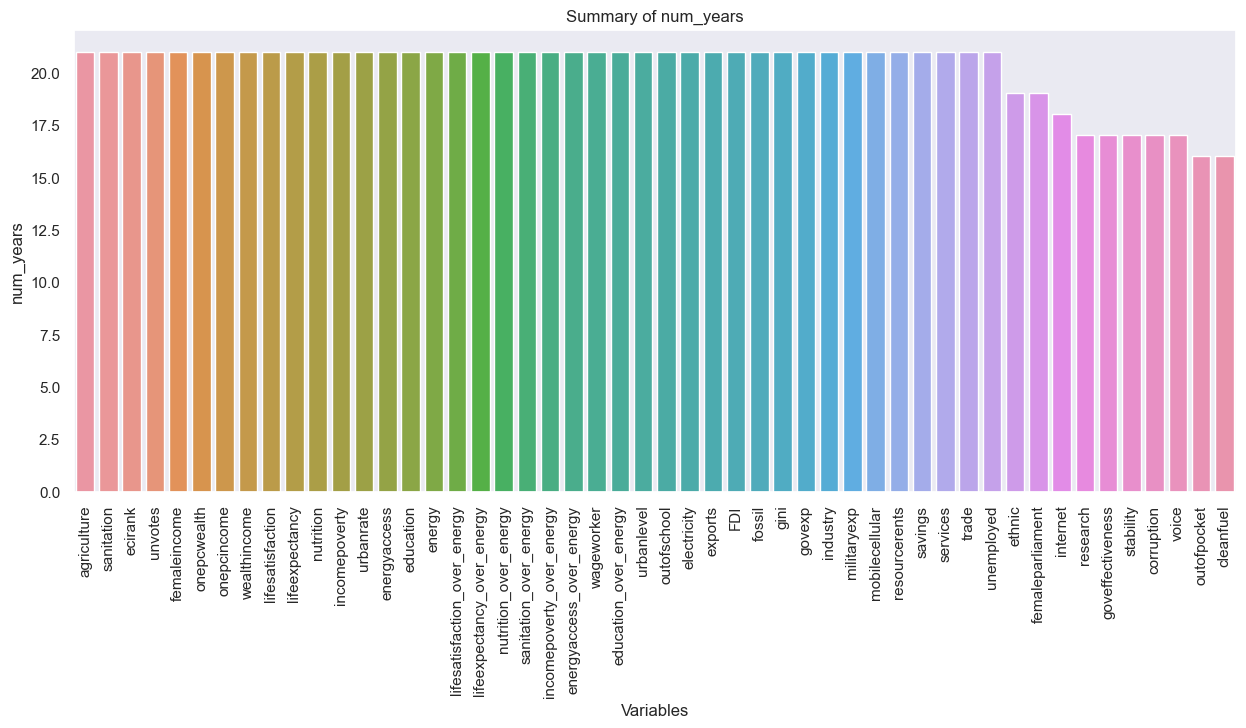

In [13]:
# plot_summary_variable(summary_dfs['lifeexpectancy_over_energy'], 'observations')
# plot_summary_variable(summary_dfs['lifeexpectancy_over_energy'], 'num_countries')
plot_summary_variable(summary_dfs['lifeexpectancy_over_energy'], 'num_years')

## Cross-validation: Best subset, Lasso, PCA

In [14]:
from sklearn.linear_model import Lasso
from sklearn.impute import KNNImputer
# from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from abess import LinearRegression
from functions.cross_validation import panel_cross_validation, plot_cross_validation_results

In [15]:
# Initialize the models
best_subset_model = LinearRegression()
lasso_model = Lasso(max_iter=10000)
pca_model = PCA()

# Combine these into a list
models = [best_subset_model, lasso_model, pca_model]
model_names = ['Best Subset', 'Lasso', 'PCA']

In [16]:
lifeexp_indicators = indicator_dfs['lifeexpectancy_over_energy']
lifeexp_outcomes = outcome_dfs['lifeexpectancy_over_energy']

In [17]:
lifeexp_model, lifeexp_cv_results = panel_cross_validation(models, model_names, lifeexp_indicators, lifeexp_outcomes)

Model: Best Subset, Mean MSE: 0.4762, Std MSE: 0.0840, n_splits: 2, Lasso alpha: None
Model: Best Subset, Mean MSE: 0.5363, Std MSE: 0.0954, n_splits: 3, Lasso alpha: None
Model: Best Subset, Mean MSE: 0.4268, Std MSE: 0.2196, n_splits: 5, Lasso alpha: None
Model: Best Subset, Mean MSE: 0.5019, Std MSE: 0.3504, n_splits: 7, Lasso alpha: None
Model: Best Subset, Mean MSE: 0.4874, Std MSE: 0.3255, n_splits: 10, Lasso alpha: None
Model: Best Subset, Mean MSE: 0.4860, Std MSE: 0.4641, n_splits: 15, Lasso alpha: None
Model: Lasso, Mean MSE: 0.4444, Std MSE: 0.1283, n_splits: 2, Lasso alpha: {'alpha': 0.01}
Model: Lasso, Mean MSE: 0.5230, Std MSE: 0.1419, n_splits: 3, Lasso alpha: {'alpha': 0.01}
Model: Lasso, Mean MSE: 0.4272, Std MSE: 0.2462, n_splits: 5, Lasso alpha: {'alpha': 0.01}
Model: Lasso, Mean MSE: 0.3954, Std MSE: 0.3343, n_splits: 7, Lasso alpha: {'alpha': 0.01}
Model: Lasso, Mean MSE: 0.4199, Std MSE: 0.3230, n_splits: 10, Lasso alpha: {'alpha': 0.01}
Model: Lasso, Mean MSE: 0.

### Anaylzing cross-validation results

In [18]:
from functions.cross_validation import filter_and_find_best_model, plot_cross_validation_results

In [19]:
# plot_cross_validation_results(lifeexp_cv_results)
best_model_no_zero_coef = filter_and_find_best_model(lifeexp_cv_results)
print(best_model_no_zero_coef)

Lasso_7


### Best model?
Best Model: Lasso, Mean MSE: 0.3953844254470721, n_splits: 7, Lasso alpha: {'alpha': 0.01}

Try removing "selfemployed" column because it's collinear with "wageworker" and "concentration" as an outlier

In [22]:
lifeexp_lasso = Pipeline([('imputer', KNNImputer(n_neighbors=5)), ('scaler', StandardScaler()),
                          ('model', Lasso(max_iter=10000, alpha=0.01))])

lifeexp_lasso.fit(lifeexp_indicators, lifeexp_outcomes)
lifeexp_lasso_coef = lifeexp_lasso.named_steps['model'].coef_

important_features = []
for i, coef in enumerate(lifeexp_lasso_coef):
    if coef != 0:
        important_features.append((i, coef))

print("Important features:", important_features)
print(lifeexp_lasso.named_steps['model'].intercept_)
indicators_lifeexp_over_energy_important = lifeexp_indicators.iloc[:, [i for i, coef in important_features]]
# indicators_lifeexp_over_energy_important_2012 = lifeexp_indicators.iloc[:,
#                                                 [i for i, coef in important_features]]
print(len(indicators_lifeexp_over_energy_important.columns), len(lifeexp_indicators.columns))

Important features: [(2, -0.2635313244891431), (3, 0.06808178743782882), (5, -0.0488847164440789), (7, 0.12008649358812054), (8, -0.024600648503361168), (10, 0.015458498173098504), (11, 0.00961917008726097), (12, -0.06267180373744628), (13, 0.06223490071806533), (16, 0.16825982368890569), (17, 0.1385879627376044), (18, -0.017664383816070064), (20, -0.07871329723955882), (21, -0.3623627398942964), (22, -0.04643657852270497), (23, -0.07090294468082818), (26, -0.07185827943279835), (27, 0.011878803226364183), (28, 0.3203173111418614), (30, -0.12786078893584632), (32, 0.03703012628423518)]
1.907376641031724
21 33


## Panel regression with cross-validation

In [23]:
# simple linear regression
from sklearn.linear_model import LinearRegression

lifeexp_lasso_linear = Pipeline([('imputer', KNNImputer(n_neighbors=5)), ('model', LinearRegression())])
lifeexp_lasso_linear.fit(indicators_lifeexp_over_energy_important, lifeexp_outcomes)
lifeexp_lasso_linear_coef = lifeexp_lasso_linear.named_steps['model'].coef_
print("Linear regression coefficients:", lifeexp_lasso_linear_coef)
print("Adjusted r squared",
      lifeexp_lasso_linear.score(indicators_lifeexp_over_energy_important, lifeexp_outcomes))

Linear regression coefficients: [-0.28645506  0.02960165 -0.05042274  0.01225031 -0.04175224  0.23391716
  0.01296372 -0.16999651  0.04256489  0.18688352  0.09366913 -0.1773028
 -0.17187978 -0.91827248 -0.12307755 -0.2864762  -0.4754402   0.05595736
  0.51070511 -0.79257957  0.12981644]
Adjusted r squared 0.6896313176292346


In [ ]:
# try the same regression only for year 2012
# lifeexp_lasso_linear_2012 = Pipeline([('imputer', KNNImputer(n_neighbors=5)), ('model', LinearRegression())])
# lifeexp_lasso_linear_2012.fit(indicators_lifeexp_over_energy_important_2012, outcome_lifeexp_over_energy_2012)
# lifeexp_lasso_linear_coef_2012 = lifeexp_lasso_linear_2012.named_steps['model'].coef_
# print("Linear regression coefficients:", lifeexp_lasso_linear_coef_2012)
# print("Adjusted r squared",
#       lifeexp_lasso_linear_2012.score(indicators_lifeexp_over_energy_important_2012, outcome_lifeexp_over_energy_2012))

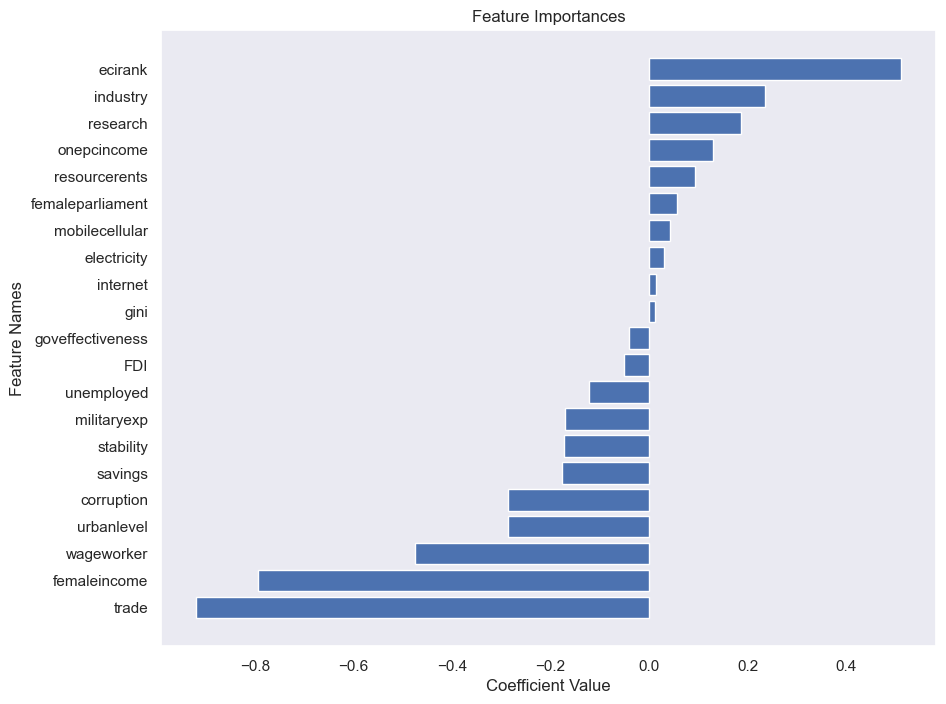

In [24]:
from matplotlib import pyplot as plt

# Extract the feature names from your DataFrame (change this line if your feature names are stored differently)
indicators_lifeexp_over_energy_names = indicators_lifeexp_over_energy_important.columns

# Create a list of (coefficient, feature_name) tuples and sort them based on the coefficients
indicators_lifeexp_over_energy_names_sorted = sorted(
    zip(lifeexp_lasso_linear_coef, indicators_lifeexp_over_energy_names))

# Separate the tuples into two lists
lifeexp_lasso_coef_sorted, lifeexp_over_energy_names_sorted = zip(*indicators_lifeexp_over_energy_names_sorted)

# Create a bar plot
plt.figure(figsize=(10, 8))
plt.barh(range(len(lifeexp_lasso_coef_sorted)), lifeexp_lasso_coef_sorted, align='center')
plt.yticks(range(len(lifeexp_lasso_coef_sorted)), lifeexp_over_energy_names_sorted)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature Names')
plt.title('Feature Importances')
plt.show()